In [1]:
import sys
sys.path.append('../')

%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from skimage.io import imread

from gen.load_data import load_data

In [3]:
from sklearn.utils import shuffle

train_df, valid_df, test_df = load_data('../data')

train_df = shuffle(train_df)
valid_df = shuffle(valid_df)

print(train_df.head())


                                                image                   id  \
516                   ../data/Train/CameraRGB/864.png                  864   
99    ../data/Train/CameraRGB/episode_0001_000229.png  episode_0001_000229   
562   ../data/Train/CameraRGB/episode_0004_000177.png  episode_0004_000177   
2312                  ../data/Train/CameraRGB/628.png                  628   
246   ../data/Train/CameraRGB/episode_0002_000288.png  episode_0002_000288   

                                                label  
516                   ../data/Train/CameraSeg/864.png  
99    ../data/Train/CameraSeg/episode_0001_000229.png  
562   ../data/Train/CameraSeg/episode_0004_000177.png  
2312                  ../data/Train/CameraSeg/628.png  
246   ../data/Train/CameraSeg/episode_0002_000288.png  


In [4]:
from models.segnet import model_segnetVGG16

model = model_segnetVGG16(3, image_shape=(480, 480, 3))
model.summary()

/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 480, 480, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 480, 480, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 480, 480, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 240, 240, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 240, 240, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 240, 240, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 120, 120, 128)     0         
__________

In [8]:
from gen.generators import train_and_lab_gen_func

BATCH_SIZE = 8
model_dir = '../saved_models/segnet/'

train_gen = train_and_lab_gen_func(train_df, image_size=(600, 800), target_size=(480, 480), batch_size = BATCH_SIZE)
valid_gen = train_and_lab_gen_func(valid_df, image_size=(600, 800), target_size=(480, 480), batch_size = BATCH_SIZE)


In [ ]:
from train import weighted_categorical_crossentropy
from keras.utils.training_utils import multi_gpu_model

weights = np.array([100, 10, 1])

gpus = 2

model_gpu = multi_gpu_model(model, gpus)
model_gpu.compile(loss=weighted_categorical_crossentropy(weights),
              optimizer='adam',
              metrics=['accuracy'])


In [13]:
from train import train_nn

m = train_df.shape[0]
history = train_nn(model_gpu, 
                   train_gen, 
                   valid_gen, 
                   training_size=m, 
                   batch_size=BATCH_SIZE,
                   validation_size=valid_df.shape[0],
                   output_path=model_dir, 
                   epochs=500,
                  gpus = 2)

/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/keras/engine/training.py:2095: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


## Ignore next message from keras, values are replaced anyways
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
## Ignore next message from keras, values are replaced anyways
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 500 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Reinserting dataframe: 500 images
## Ignore next message from keras, values are replaced anyways
## Ignore next message from keras, values are replaced anyways
Reinserting dataframe: 500 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
## Ignore next message from keras, values are replaced anyways
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 clas

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



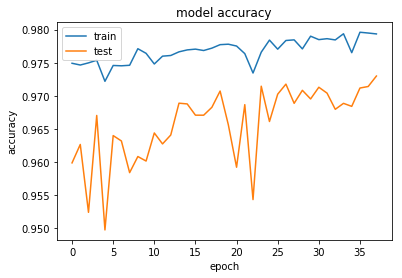

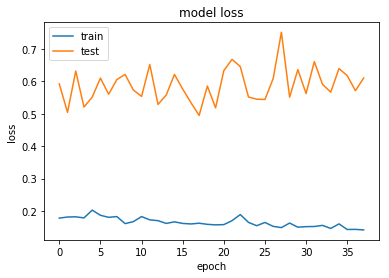

In [14]:
# # summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
model.save('../saved_models/segnet/model_saved.h5')

In [ ]:
#valid_gen = train_and_lab_gen_func(valid_df, image_size=(600, 800), target_size=(480, 480), batch_size = BATCH_SIZE * gpus)
#test_gen = train_and_lab_gen_func(test_df, image_size=(600, 800),  target_size=(480, 480),  batch_size = BATCH_SIZE * gpus)